In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from pinneit import Circ, Rect, plot_geo, exclude_points_in_region, plot_prediction

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

2024-11-07 10:14:38.770008: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-07 10:14:39.387464: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
Ω = Rect(-1, -1, 2, 2)
Γ1 = Circ(-0.5, 0, 0.1)
Γ2 = Circ(0.5, 0, 0.1)

Got a list of 3 geometries.


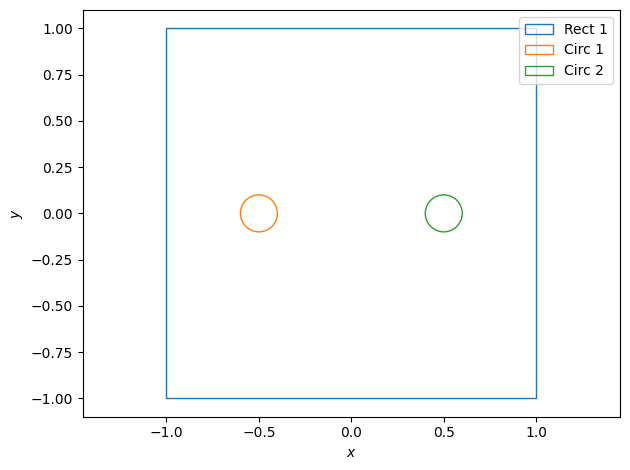

In [3]:
plot_geo([Ω, Γ1, Γ2])

In [4]:
dΓ1_pts = Γ1.generate_edge_points(n_pts=1_000)
dΓ2_pts = Γ2.generate_edge_points(n_pts=1_000)
dΓ_pts = np.vstack((dΓ1_pts,dΓ2_pts))

sΩ_pts = Ω.generate_surface_points(n_pts=5000)
sΩ_pts = exclude_points_in_region(sΩ_pts, [Γ1,Γ2])
dΩ_pts = Ω.generate_edge_points(n_pts=2_000)

print(dΓ1_pts.shape, dΓ2_pts.shape, dΩ_pts.shape, sΩ_pts.shape)

Got a list of 2 geometries to exclude.
(1000, 2) (1000, 2) (2000, 2) (4904, 2)


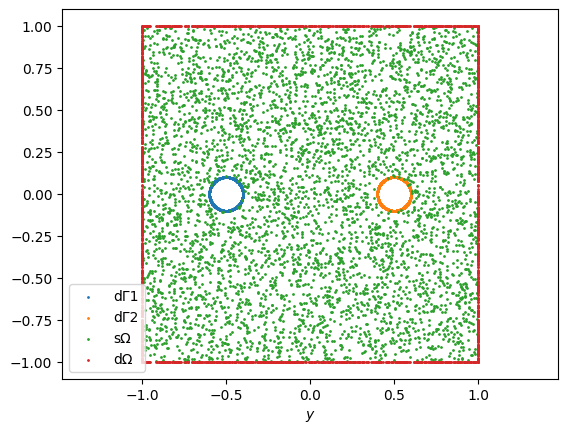

In [5]:
plt.scatter(dΓ1_pts[:, 0], dΓ1_pts[:, 1], s=1, label="dΓ1")
plt.scatter(dΓ2_pts[:, 0], dΓ2_pts[:, 1], s=1, label="dΓ2")
plt.scatter(sΩ_pts[:, 0], sΩ_pts[:, 1], s=1, label="sΩ")
plt.scatter(dΩ_pts[:, 0], dΩ_pts[:, 1], s=1, label="dΩ")
plt.xlabel("$x$")
plt.xlabel("$y$")
plt.axis("equal")
plt.legend()
plt.show()

**Train PINN**

(4904, 2) (4000, 2) (4000,)


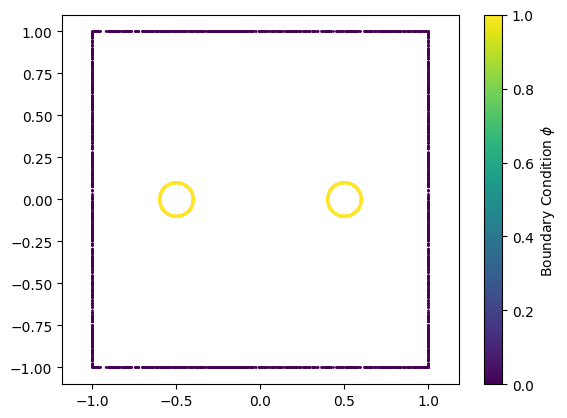

In [10]:
# TBD: write function for automatic BCs
X_b = np.concatenate((dΩ_pts, dΓ1_pts, dΓ2_pts))
y_b = np.concatenate(
    (
        np.zeros(dΩ_pts.shape[0]),
        np.ones(dΓ1_pts.shape[0]) * 1,
        np.ones(dΓ2_pts.shape[0]) * 1,
    )
)
assert X_b.shape[0] == y_b.shape[0]
shffls_idx = np.random.permutation(y_b.shape[0])

X = X_b[shffls_idx]
y = y_b[shffls_idx]

Pts = tf.constant(sΩ_pts, dtype=tf.float32)
X = tf.constant(X, dtype=tf.float32)
y = tf.constant(y, dtype=tf.float32)

print(Pts.shape, X.shape, y.shape)

X_f, X_b, y_b = Pts, X, y

plt.scatter(X_b[:, 0], X_b[:, 1], c=y_b, s=1)
plt.axis("equal")
plt.colorbar(label="Boundary Condition $\phi$")
plt.show()

In [ ]:
class PINN(tf.keras.Model):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = []
        for width in layers[:-1]:
            self.hidden_layers.append(tf.keras.layers.Dense(width, activation='tanh'))
        self.output_layer = tf.keras.layers.Dense(layers[-1], activation=None)
    
    def call(self, X):
        x = X
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

# PDE residual function: Laplace's equation (Delta u = 0)
def pde_residual(model, interior_points):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(interior_points)
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(interior_points)
            u_pred = model(interior_points)
        u_x = tape.gradient(u_pred, interior_points)[:, 0:1]
        u_y = tape.gradient(u_pred, interior_points)[:, 1:2]
    u_xx = tape2.gradient(u_x, interior_points)[:, 0:1]
    u_yy = tape2.gradient(u_y, interior_points)[:, 1:2]
    del tape, tape2
    return u_xx + u_yy  # Laplacian u_xx + u_yy = 0


def compute_loss(model, interior_points, outer_boundary_points, outer_boundary_values, electrode_boundary_points, electrode_boundary_values):
    pde_loss = tf.reduce_mean(tf.square(pde_residual(model, interior_points)))
    
    u_outer_pred = model(outer_boundary_points)
    outer_bc_loss = tf.reduce_mean(tf.square(u_outer_pred - outer_boundary_values))
    
    u_electrode_pred = model(electrode_boundary_points)
    electrode_bc_loss = tf.reduce_mean(tf.square(u_electrode_pred - electrode_boundary_values))
    
    total_loss = pde_loss + outer_bc_loss + electrode_bc_loss
    return total_loss


# @tf.function
def train_pinn(model, interior_points, outer_boundary_points, electrode_boundary_points, epochs, lr=1e-3):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    outer_boundary_values = tf.zeros((outer_boundary_points.shape[0], 1))
    electrode_boundary_values = tf.ones((electrode_boundary_points.shape[0], 1))

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            loss = compute_loss(model, interior_points, outer_boundary_points, outer_boundary_values, electrode_boundary_points, electrode_boundary_values)
        
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        if epoch % 100 == 0:
            tf.print(f"Epoch {epoch}, Loss: {loss.numpy():.6f}")


# Sampling
interior_points = X_f
outer_boundary_points = dΩ_pts
electrode_boundary_points = dΓ_pts

# Convert to TensorFlow tensors
interior_points = tf.convert_to_tensor(interior_points, dtype=tf.float32)
outer_boundary_points = tf.convert_to_tensor(outer_boundary_points, dtype=tf.float32)
electrode_boundary_points = tf.convert_to_tensor(electrode_boundary_points, dtype=tf.float32)

# Build and train the PINN model
layers = [2, 28, 28, 28,28,28, 1]  # 2 inputs (x, y), 3 hidden layers with 20 neurons, 1 output (u)
pinn_model = PINN(layers)

# Train the PINN
train_pinn(pinn_model, interior_points, outer_boundary_points, electrode_boundary_points, epochs=5000, lr=1e-3)

Epoch 0, Loss: 1.233325


In [ ]:
X, Y, grid_points = Ω.generate_grid()

grid_points_tf = tf.convert_to_tensor(grid_points, dtype=tf.float32)
u_pred = pinn_model(grid_points_tf)
u_pred = u_pred.numpy()

plot_prediction(X, Y, u_pred)